In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import bisect
from scipy import spatial

import inv_cdfs as icdf
import agents_network as anet
import utils

We start by creating $n$ agents which are in $\mathbb{R}^p$. These agents are split in two groups, some of them are labelled $y=1$ and others $y=2$.

In [2]:
npeers, p = 250, 2 # number of agents, dimension
nsamples = np.random.randint(20,50,size=npeers)

n1 = int(npeers/2)
n2 = npeers-n1
t, R = 2*np.pi*np.random.randn(n1,1), 3
r = R*(1.5 + .2*np.random.randn(n1,1)) # radius
X1 = np.hstack((np.cos(t)*r, np.sin(t)*r));
X = np.vstack((X1, np.random.randn(n2,2)))
y = np.vstack(( np.ones([n1,1]), 2*np.ones([n2,1]) ))

We plot the agents. Those in blue are labelled $y=1$ and in orange are labelled $y=2$.

(-6.125808203176305, 6.283010228589661, -6.214428045454958, 6.724922976693267)

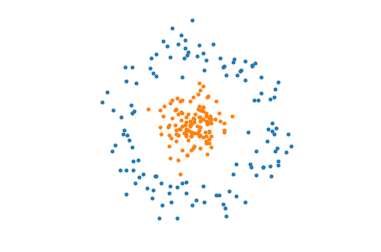

In [3]:
I = np.nonzero(y==1)[0]
J = np.nonzero(y==2)[0]
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')

The following function generate specific datas for each agent. Depending on their labelled and $\|x\|_2$, each agent received data from different distributions.

In [4]:
def create_data(x, y ,nsamples=1000):
    if y==1:
        data = np.random.poisson(np.linalg.norm(x), nsamples)
    elif y==2:
        #data = ss.expon.rvs(np.linalg.norm(x), size=nsamples)
        data = ss.norm.rvs(np.linalg.norm(x), size=nsamples)
    else:
        print("choose y in {1,2}")
    return data

We define DATA to be list of data received by each agent. Then, we plot two examples :

In [5]:
DATA = [create_data(X[k], y[k], nsamples=nsamples[k]) for k in range(npeers)]

i, j = np.random.choice(I), np.random.choice(J)
print('i=', i, 'et j=', j)
print('data for an element of I : ', DATA[i][:10])
print('data for an element of J : ', DATA[j][:5])

i= 24 et j= 232
data for an element of I :  [3 3 5 3 3 3 3 5 6 4]
data for an element of J :  [ 1.85854978  2.96677776  2.69631141 -1.48939148  1.46628193]


We build the similarity matrix.

In [6]:
def distmat(X, Z):
    return spatial.distance.cdist(X,Z)**2

def Similarities_knn(X,k,sigma):    
    similarities = np.exp( -distmat(X,X)/(2*sigma**2) )
    np.fill_diagonal(similarities, 0)
    ind = np.argsort(-similarities, axis=1)
    ind =  ind[:,0:k].flatten()
    index = np.zeros_like(similarities)
    for i,x in enumerate(ind):
        index[i//k,x] = 1
    similarities = similarities*(index+index.T>0)
    return similarities

We look the similarity matrix thanks to the functions defines above.

[0.88416876 0.65001105 0.72525602 0.98185906 0.4313274  0.99541048
 0.72680027 0.46590213 0.63722565 0.88781397]


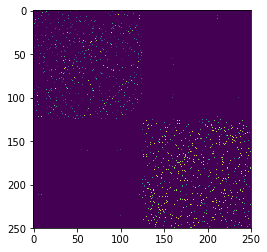

In [7]:
sigma, k = 0.5, 5
W = Similarities_knn(X,k,sigma)
plt.imshow(W)
print(np.max(W, axis=1)[:10])

Now, we define two methods to calculate density functions from datas :

In [8]:
def methode_Noyau(data, K=ss.norm.pdf):
    nsamples = len(data)
    sigma = data.std()
    h = sigma/nsamples**(0.2) # thumb rule
    densite = lambda y : np.sum([K((y-x)/h) for x in data])/(nsamples*h)
    return densite

def methode_MC(data):
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob =  Nb_occurences/np.sum(Nb_occurences)
    return ensemble_des_valeurs, prob

We plot the density got from an agent labelled $y=1$.

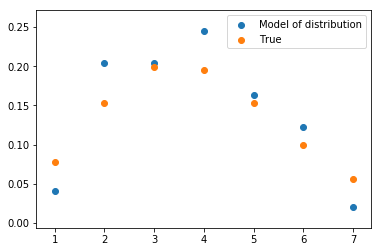

In [9]:
data = DATA[i]
ensemble_des_valeurs, prob = methode_MC(data)
plt.scatter(ensemble_des_valeurs, prob, label='Model of distribution')
plt.scatter(ensemble_des_valeurs, ss.poisson.pmf(ensemble_des_valeurs,np.linalg.norm(X[i])), label='True')
plt.legend()

We plot the density got from an agent labelled $y=2$.

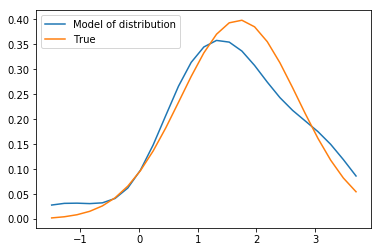

In [10]:
data = DATA[j]
densite = methode_Noyau(data)
tt = np.linspace(np.min(data), np.max(data), 25)
plt.plot(tt, [densite(t) for t in tt], label='Model of distribution')
plt.plot(tt, ss.norm.pdf(tt,np.linalg.norm(X[j])), label='True')
plt.legend()

Once we have the densities, we need the functions $g_s(v)$. Firstly, we define the cumulative empirical function $F$, and then $g$ represents its inverse. 

In [11]:
def F(data):
    nsamples = len(data)
    data_sorted = np.sort(data)
    return lambda t : bisect.bisect(data_sorted,t)/nsamples

def g(data):
    nsamples = len(data)
    ensemble_des_valeurs, Nb_occurences = np.unique(data, return_counts=True)
    prob_cum = np.cumsum(Nb_occurences)/nsamples
    return prob_cum, ensemble_des_valeurs

For $u,v$ two neighbors, we can build $g_s(u)$ and $g_s(v)$:

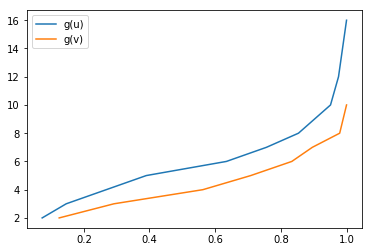

In [12]:
G = [g(data) for data in DATA]
u = np.random.randint(npeers)
v = np.argmax(W[u])

xx, yy = G[u]
plt.plot(xx, yy, label='g(u)')
xx, yy = G[v]
plt.plot(xx, yy, label='g(v)')
plt.legend()

We find that neighbor agents have very similar distributions. In conclusion, they can exchange information to better learn their models. Now we use the data to define the agents and their models.

In [13]:
invcdfs = utils.invcdfs_from_data(DATA, nsamples_icdf=10000)

Let's show some functions of empirical distributions of laws $\mathcal{P}(\|x\|)$ :

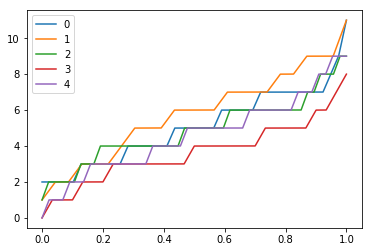

In [14]:
utils.plot_invcdfs(invcdfs[0:5])

We display distribution functions generated by datas from $\mathcal{N}(\|x\|,1)$ :

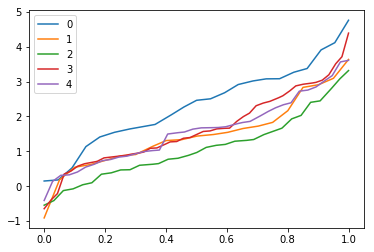

In [15]:
utils.plot_invcdfs(invcdfs[-5:])

In the cell below, we define the network:

In [16]:
# Stack agents in a list
agents = [anet.Agent(npeers, k, invcdfs[k]) for k in range(npeers)]

# The confidence in every model is proportional to its amount of datas
C = nsamples/np.max(nsamples)

# Build networks
network = anet.AgentNetwork(W, C, agents, mu=0.8)

Finally, we measure the error by looking at the difference between the real and empirical distribution function, we display the evolution of the average error according to the number of communications:

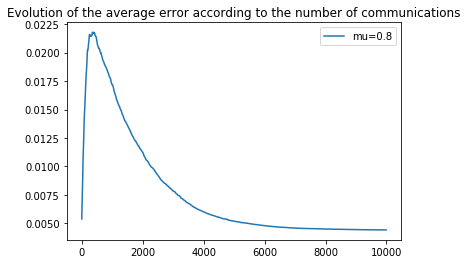

In [17]:
invcdfs = utils.invcdfs_from_data(DATA, nsamples_icdf=10000)
agents = [anet.Agent(npeers, k, invcdfs[k]) for k in range(npeers)]
network = anet.AgentNetwork(W, C, agents, mu=0.8)

Error_L2 = []
nb_it = 1000

for n in range(nb_it):
    models_sol, models_final = utils.extract_models_continuous(network,
                                                           start_cdf=0,
                                                           stop_cdf=13,
                                                           nsamples_cdf=1000,
                                                           nbins=400)
    Error = []
    for k in range(npeers):
        tt = models_final[k].ts
        if y[k]==1:
            Cdf_True = ss.poisson.cdf(tt, mu=np.linalg.norm(X[k]))
        else : 
            Cdf_True = ss.norm.cdf(tt, loc=np.linalg.norm(X[k]))
        Error.append(np.linalg.norm(Cdf_True-models_final[k].cdf))
    
    Error_L2.append(np.mean(Error))
    network.iterate_async_gossip(10)
    

plt.plot(10*np.arange(nb_it), np.array(Error_L2)/npeers, label='mu=0.8')
plt.title('Evolution of the average error according to the number of communications')
plt.legend()